# What shapes are our iPSCs?

Cell morphology in general, and cell shape in particular, provide a readout of organizational and physiological cell state. In evaluating cell health or state, we frequently make inferences from the outline and texture of the cell's membrane. This is easy to do on a cell-by-cell basis but becomes substantially harder when confronted by a population of hundreds or thousands of cells. 

One of the data products produced by the [Allen Inst for Cell Science](http://allencell.org/) is a large corpus of segmented cell and nuclear shapes. These are a necessary step in the isolation of individual cells from our [high-magnification fields of cells](http://cellviewer-1-1-0.allencell.org/client_service/?name=AICS-10_28&dim=3D&cellMaskOn=false). 

These segmentations are appealingly simple way to characterize cell shape, being nothing more than True/False (cell/not-cell) matrices. To help build intuition about cell shape across our population, let's take a look at a decomposition that tells us the mean cell shape and breaks out shape variation along a couple of axes. 

In [1]:
# Load some supporting packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_context('notebook')
from tqdm import tqdm

Let's load our cells and nuclei. You can get them [here](https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_cell_segmentations.npz) and [here](https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_nuclear_segmentations.npz) or `wget` them as described below.

In [2]:
#!wget https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_cell_segmentations.npz
#!wget https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_nuclear_segmentations.npz

cells = np.load("20170919_cell_segmentations.npz")
nucs = np.load("20170919_nuclear_segmentations.npz")
names = cells.keys()
print("We found %i cell segmentations"%len(names))

We found 15758 cell segmentations


What do our cells look like? We'll need to define some plotting helper functions first and then we can plot our cells. 

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

def plot_volume(volume, ax, zoom=8):
    """Find the mesh for a segmentation and plot it as a surface"""
    verts, faces, normals, values = measure.marching_cubes_lewiner(volume)
    x, y, z = verts.T
    ax.plot_trisurf(x, y, faces, z, lw=0, cmap=plt.cm.Paired)
    ax.set_axis_off()  # look nice with no axes 
    ax.dist = zoom     # how far from axis we want to be
    ax.set(aspect=1, facecolor="white")

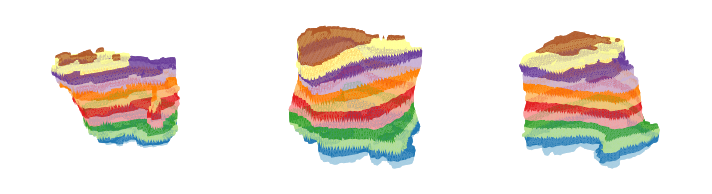

In [4]:
# Now plot our cells
sample_cells = [cells[name] for name in names[:3]]
fig, axes = plt.subplots(1, 3, figsize=(10,3), subplot_kw={"projection":"3d"})
for ax, cell in zip(axes, sample_cells):
    plot_volume(cell, ax)
plt.tight_layout()

Our cells look good in stripes! Also, it helps us see their contours. 

So we've got a very nice number of cells loaded. Let's find their principle components. We'll do this over a number of batches and use multithreading but it will still take some time.

In [14]:
from sklearn.decomposition import IncrementalPCA

cell_ipca = IncrementalPCA(n_components=20)
nuc_ipca = IncrementalPCA(n_components=20)

for batch_names in tqdm(np.array_split(names, 100)):
    cell_batch = np.vstack([cells[n].flatten() for n in batch_names])
    nucs_batch = np.vstack([nucs[n].flatten() for n in batch_names])
    cell_ipca.partial_fit(cell_batch)
    nuc_ipca.partial_fit(nucs_batch)

100%|██████████| 100/100 [1:51:49<00:00, 67.10s/it]


In [22]:
## Delete this next bit for the rendered file, it is a testing shortcut.
#import pickle 
#with open("cell_ipca.pkl", 'wb') as file: 
#    pickle.dump(cell_ipca, file)
#with open("nuc_ipca.pkl", 'wb') as file: 
#    pickle.dump(nuc_ipca, file)
#with open("cell_ipca.pkl", 'rb') as file: 
#    cell_ipca = pickle.load(file)
#with open("nuc_ipca.pkl", 'rb') as file: 
#    nuc_ipca = pickle.load(file)

How well do those do at explaining the variance?

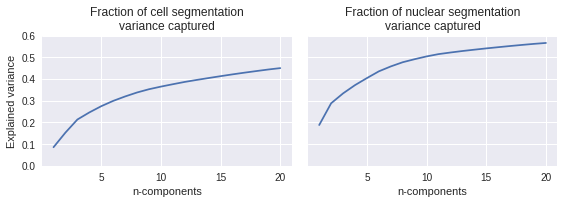

In [17]:
# How much variance is explained?
cell_variance = np.cumsum(cell_ipca.explained_variance_ratio_)
nuc_variance = np.cumsum(nuc_ipca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Plot variance
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
axes[0].plot(component_number, cell_variance)
axes[0].set(ylim=(0,.6), 
            xlabel="n-components", 
            ylabel="Explained variance",
            title="Fraction of cell segmentation\nvariance captured")
axes[1].plot(component_number, nuc_variance)
axes[1].set(xlabel="n-components", 
            title="Fraction of nuclear segmentation\nvariance captured")

plt.tight_layout()

These capture a middle amount of the natural variation seen in the cell outlines. It is a fair bit easier to capture nuclear variance than to capture cell shape variance, likely because the nucleus is a more stereotyped shape. 

What do the principle components look like? Let's see how they are distributed by calculating them for a subset of the cells we trained on. Since the information content levels off and it would be cluttered to look at all 20 components, I'll limit this to the first 6.

In [18]:
# Select and prep 1K samples
n = 1000
inds = np.linspace(0,len(names)-1, n, dtype=np.int)
sample_cells = np.reshape([cells[names[i]] for i in inds], (n,-1))
sample_nucs = np.reshape([nucs[names[i]] for i in inds], (n,-1))

# Calculate weights
cell_weights = cell_ipca.transform(sample_cells)
nuc_weights = nuc_ipca.transform(sample_nucs)

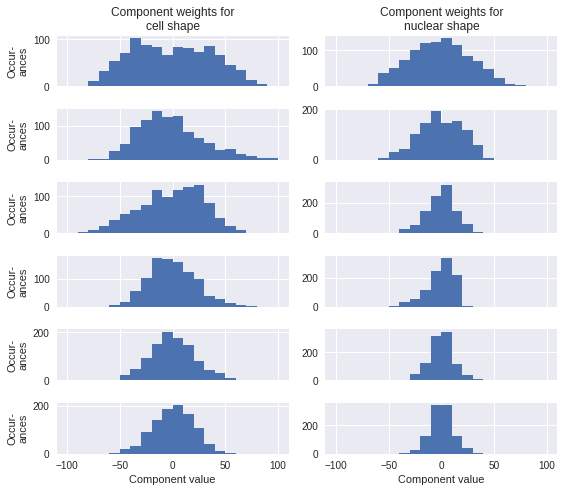

In [19]:
fig, axes = plt.subplots(6, 2, figsize=(8,7), sharex=True)
for i, ax in enumerate(axes[:,0]):
    ax.hist(cell_weights[:,i], 20, (-100,100))
for i, ax in enumerate(axes[:,1]):
    ax.hist(nuc_weights[:,i], 20, (-100,100))
    
axes[0,0].set_title("Component weights for\ncell shape")
axes[0,1].set_title("Component weights for\nnuclear shape")
[ax.set_ylabel("Occur-\nances") for ax in axes[:,0]];
[ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()

None of those are so bimodal or otherwise non-normally distributed that we can't get a sense of what their effects are on the overall cell shape just by looking at the effect of reconstructing a cell with the mean shape plus one of the components set to its 10th or 90th percentile value. 

Let's create reconstructions of the mean cell and nucleus with component perturbations. 

In [20]:
## Some supporting information first
percentiles = (10,90)
cell_percentiles = np.percentile(cell_weights, percentiles, 0).T
nuc_percentiles = np.percentile(nuc_weights, percentiles, 0).T
original_shape = cells[names[0]].shape
reconstruct = lambda mean, weight, component: 0.05<(mean+weight*component).reshape(*original_shape)

## Reconstruct the cells along the principle components
cells_along_princ_comps = []
for weight, comp in zip(cell_percentiles, cell_ipca.components_):
    cell_lo = reconstruct(cell_ipca.mean_, weight[0], comp)
    cell_hi = reconstruct(cell_ipca.mean_, weight[1], comp)
    cells_along_princ_comps.append([cell_lo, cell_hi])

## Do the same for the nuclei
nucs_along_princ_comps = []
for weight, comp in zip(nuc_percentiles, nuc_ipca.components_):
    nuc_lo = reconstruct(nuc_ipca.mean_, weight[0], comp)
    nuc_hi = reconstruct(nuc_ipca.mean_, weight[1], comp)
    nucs_along_princ_comps.append([nuc_lo, nuc_hi])

With reconstructions in hand, the last task is to visualize them. 

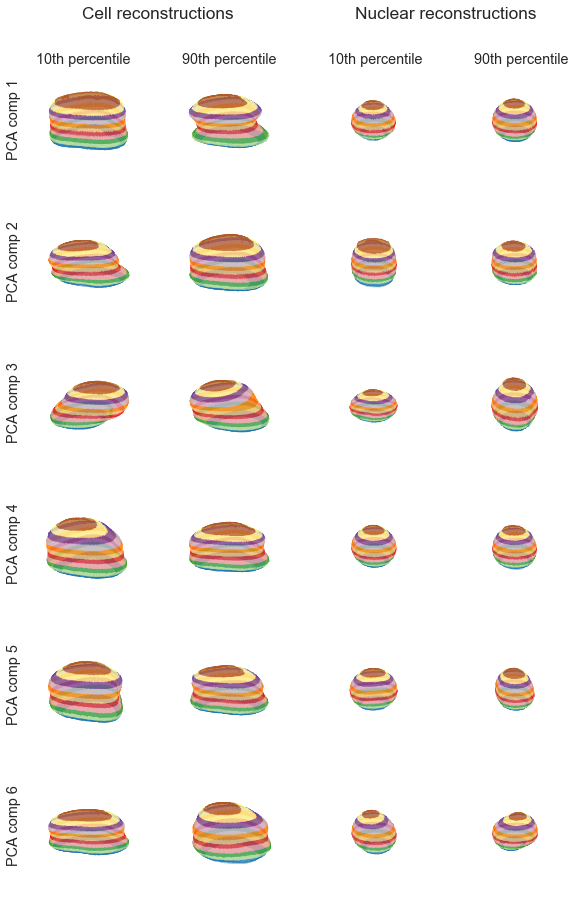

In [21]:
## Cell reconstruction
fig, axes = plt.subplots(6, 4, figsize=(8,14), subplot_kw={"projection":"3d"})
for i, row in enumerate(axes):
    plot_volume(cells_along_princ_comps[i][0], row[0])
    plot_volume(cells_along_princ_comps[i][1], row[1])
    plot_volume(nucs_along_princ_comps[i][0], row[2], 14)
    plot_volume(nucs_along_princ_comps[i][1], row[3], 14)

## Complicated labeling, simple versions don't work with 3d projections
title_props = {'size':'x-large', 'horizontalalignment':'center'}
label_props = {'size':'large', 'horizontalalignment':'center', 'verticalalignment':'center'}
fig.text(.25,.92, "Cell reconstructions", **title_props)
fig.text(.75,.92, "Nuclear reconstructions", **title_props)
for i, x in zip((10,90,10,90), np.linspace(.12,.88,4)):
    fig.text(x,.88,"%ith percentile"%i, **label_props)
for i, y in enumerate(np.linspace(.82,.12,6)):
    fig.text(0,y, "PCA comp %i"%(i+1), rotation='vertical', **label_props)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])

The cell components exhibit more interpretable variation, as expected. The first cell component describes whether the cell has a narrow or straight waist, the second (perhaps) whether the cell spreads at the bottom, the third is a rotational artifact, and the higher components become difficult to interpret. 

The first nuclear component is maybe an indicator of having a sharp waist. The second and third nuclear components are cylindrical/sphere and pancake/sphere, respectively. As with the cell components, high order nuclear components become harder to interpret. 